In [96]:
import ray
from ray import tune
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import  seaborn as sns
import learning_lidar.utils.global_settings as gs
import matplotlib as mpl
sns.set_palette(sns.color_palette("tab10"))

plt.rcParams['figure.dpi'] = gs.FIGURE_DPI
plt.rcParams['savefig.dpi'] = gs.SAVEFIG_DPI

sns.set_theme()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [97]:
def extract_powers(row, in_channels):
    powers = eval(row['powers']) if type(row['powers'])==str else None
    pow_y = np.array(powers[1])[0] if type(powers)==tuple else None
    pow_x = np.array(powers[0]) if type(powers)==tuple else None
    pow_xi = np.zeros(in_channels)
    if type(pow_x)==np.ndarray:
        for chan in range(in_channels):
            pow_xi[chan] = pow_x[chan] if  (len(pow_x)>=chan+1) else None
    else:
        for chan in range(in_channels):
            pow_xi[chan] = None
    return [pow_y,*pow_xi]

In [98]:
base_folder = os.path.dirname(os.path.dirname(os.path.abspath(os.curdir)))
results_folder = os.path.join(base_folder, 'results')

# postprocessing LCNET results from jason state files saved in  `runs_board.xlsx`

In [99]:
runs_df = pd.read_excel(os.path.join(results_folder,'runs_board.xlsx'))
runs_df = runs_df[runs_df.include==True][runs_df.state!='PENDING']

<ipython-input-99-909af9a4e9d6>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  runs_df = runs_df[runs_df.include==True][runs_df.state!='PENDING']


In [100]:
runs_df

,hidden_sizes,bsize,FC_sizes,LR,dfilter,power,normalize,use_bg,inputs,experiment_folder,state,field_to_ignore,trial_to_ignore,include,test_goal,note,comments,results_csv
14,"[3,3,3,3],[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,False,"([0.5,0.25,1],[0.5]),([0.5,0.5,1],[0.5]), ([0....",False,True,"lidar,molecular,bg",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,1.0,Additional bg channel,initial_db,Fixed zeroed days. Validate prev results,NaN
15,"[3,3,3,3],[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,False,"([0.5,0.25],[0.5]),([0.5,0.5],[0.5]), ([0.5,-0...",False,False,"lidar,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,1.0,"hsize, fc_size, pow_x2",initial_db,Fixed zeroed days. Validate prev results,NaN
16,"[3,3,3,3],[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,False,"([0.5,0.5,0.5],[0.5]),([0.5,-0.25,0.5],[0.5]),...",False,range_corr,"lidar,molecular,bg*r^2",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,1.0,Additional bg channel - range corrected,initial_db,NaN,NaN
17,"[1,1,1,1] , [2,2,2,2] , [3,3,3,3],[4,4,4,4], [...","32,64","[4,16,32]","0.0001,0.0005",False,"([0.5,-0.25,1],[0.5])",False,"FALSE,TRUE","lidar,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,1.0,Verify prev results,initial_db,NaN,NaN
18,"[3,3,3,3],[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]","0.001,0.002",False,"([0.5,-0.25,-0.5],[0.5])",False,True,"lidar,molecular,bg",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,1.0,Additional bg channel- power transform,initial_db,NaN,NaN
19,"[3,3,3,3],[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]","0.001,0.002,0.004",False,"([0.5,-0.25],[0.5])",False,False,"signal,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,1.0,different sources,initial_db,NaN,NaN
20,"[3,3,3,3],[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]","0.001,0.002,0.004",False,"([0.5,-0.25],[0.5])",False,False,"signal_p,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,1.0,different sources,initial_db,NaN,NaN
21,"[4,4,4,1],[4,4,4,2],[4,4,4,3],[5,5,5,1],[5,5,5...",32,"[16,32]",0.001,False,"([0.5,-0.25],[0.5]),([0.5,0.25],[0.5])",False,False,"lidar,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,1.0,"hsize, fc_size, pow_x2",initial_db,"compare to [4,4,4,4] and [5,5,5,5]",NaN
22,"[3,3,3,1],[3,3,3,2], [4,16,8,2]",32,"[16,32]",0.001,False,"([0.5,-0.25],[0.5]),([0.5,0.25],[0.5])",False,False,"lidar,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,1.0,"hsize, fc_size, pow_x2",initial_db,"compare to [4,4,4,4] and [5,5,5,5]",NaN
23,"[4,8,16,2], [4,8,8,2],[2,4,8,2]",32,"[16,32]",0.001,False,"([0.5,-0.25],[0.5]),([0.5,0.25],[0.5])",False,False,"lidar,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,1.0,"hsize, fc_size, pow_x2",initial_db,"compare to [4,4,4,4] and [5,5,5,5]",NaN


In [101]:
for idx,row in runs_df.iterrows():
    #row = runs_df.iloc[idx]
    try:
        state_fname = sorted(glob.glob(os.path.join( row.experiment_folder,r'experiment_state*.json')))[-1]
        analysis = tune.ExperimentAnalysis(state_fname)
        ignore_MARELoss = "MARELoss" in [row.field_to_ignore]
        analysis.default_metric = "MARELoss" if ignore_MARELoss else "MARELoss"
        analysis.default_mode="min"
        results_df = analysis.dataframe(metric="MARELoss", mode="min",)

        # update fields:
        if ignore_MARELoss:
            results_df["MARELoss"]=None

        # rename column names:
        cols = results_df.columns.values.tolist()
        new_cols = [col.replace('config/',"") for col in cols]
        dict_cols ={}
        for col,new_col in zip(cols, new_cols):
            dict_cols.update({col:new_col})
        results_df = results_df.rename(columns= dict_cols)

        # update power values:
        len_pow = len(results_df[results_df.use_power==True])
        len_no_pow = len(results_df[results_df.use_power==False])
        len_pows = len(results_df[results_df.use_power !=False])
        if len_no_pow>0:
            results_df.loc[results_df[results_df.use_power==False].index,'powers']= ''
        if len_pows!=len_pow:
            results_df.loc[results_df[results_df.use_power!=False].index,'powers']=results_df.use_power
            results_df.loc[results_df[results_df.use_power!=False].index,'use_power']=True
        else:
            results_df.loc[results_df[results_df.use_power==True].index,'powers']= '([0.5,0.5],[0.5])'

        # Update Notes
        note = row['note']
        results_df['note']= note if type(note)==str else 'ok'

        # drop irrelevant columns:
        drop_cols = [ 'time_this_iter_s', 'should_checkpoint', 'done',
                   'timesteps_total', 'episodes_total',
                   'experiment_id',  'timestamp',  'pid', 'hostname',
                   'node_ip', 'time_since_restore', 'timesteps_since_restore',
                   'iterations_since_restore']
        results_df.drop(columns=drop_cols,inplace=True)


        # reorganize columns:
        new_order = ['trial_id', 'date','time_total_s','training_iteration',
                     'loss', 'MARELoss',
                     'bsize', 'dfilter', 'dnorm','fc_size', 'hsizes', 'lr',
                     'ltype', 'source', 'use_bg', 'use_power','powers','note','logdir']
        results_df = results_df.reindex(columns=new_order)

        # keep index trial (especially for cases when trails are ignored)
        #results_df['idx']=results_df.index
        #new_cols = ['idx']
        #new_cols.extend(cols)
        #results_df = results_df.reindex(columns=new_cols)

        # remove irrelevant trials (e.g. when dnorm had wrong calculation)
        if row.trial_to_ignore is not np.nan:
            key,cond = eval(row.trial_to_ignore)
            results_df.drop(index=results_df[results_df[key]==cond].index,inplace=True)

        # save csv
        results_csv = os.path.join(analysis._experiment_dir, f'experiment_results.csv')
        results_df.to_csv(results_csv, index=False)

        # update csv path in main runs_board
        runs_df.loc[idx,'results_csv']=results_csv
        print(results_csv,idx)

    except:
        continue
# TODO: save runs_df with results_csv paths

# %%

#runs_df


# %% concatante all csv files with include =1

paths = [row['results_csv'] for idx,row in runs_df.iterrows()]
results_dfs=[pd.read_csv(path) for path in paths]
total_results = pd.concat(results_dfs,ignore_index=True)
# %%
total_results['fc_size'] = total_results.fc_size.apply(lambda x: eval(str(x))[0])
# update powers
in_channels = 3
res= total_results.apply(extract_powers,args=(in_channels,), axis=1, result_type='expand')
cols_powx = [f"pow_x{ind+1}" for ind in range(in_channels)]
res.rename( columns={0:'pow_y',1:cols_powx[0],2:cols_powx[1],3:cols_powx[2]},inplace=True)
total_results[res.columns.values] = res
total_results['powers'] = total_results.powers.apply(lambda x: eval(x) if type(x)==str else None)

# %%

hsizes=total_results.hsizes.apply(lambda x: eval(x))
total_results['u_hsize']=hsizes.apply(lambda x: all([(hi==x[0]) for hi in x])) # The test of changing the with at the last level , didn't show improvements

# %%

dfilter = eval(total_results.dfilter.iloc[-1])
[filter_by,filter_values] = eval(total_results.dfilter.iloc[-1])
#self.filter_values = data_filter[1]
[filter_by,filter_values]
tuple(filter_values) if len(filter_values)>1 else filter_values[0]

# %%

wavelengths=[]
filtered = total_results.dfilter.apply(lambda x:type(x)==str)
inds = total_results.dfilter[filtered].index
for ind,f in enumerate(filtered):
    if f:
        [filter_by,filter_values] = eval(total_results.dfilter.iloc[ind])
        if filter_by=='wavelength':
            wavelength = tuple(filter_values) if len(filter_values)>1 else filter_values[0]
        else:
            wavelength = 'all'
    else:
        wavelength='all'
    wavelengths.append(wavelength)

total_results['wavelength'] = wavelengths



analyse_results = total_results[total_results.training_iteration>=1]
#analyse_results = analyse_results[analyse_results.note=='ok']
analyse_results = analyse_results[analyse_results.u_hsize]

No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.

C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-20_07-01-41\experiment_results.csv 14
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-20_13-05-53\experiment_results.csv 15
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-21_01-40-10\experiment_results.csv 16
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-21_12-12-43\experiment_results.csv 17
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-22_20-09-17\experiment_results.csv 18
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-22_23-36-51\experiment_results.csv 19
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-23_19-35-00\experiment_results.csv 20
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-23_23-40-05\experiment_results.csv 21
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-24_08-38-28\experiment_results.csv 22
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\m

In [109]:
configs= []
for idx,row in analyse_results.iterrows():
    hsize = eval(row.hsizes)[0]
    fcsize = row.fc_size
    if (hsize==4) and (fcsize==16):
        configs.append('A')
    elif (hsize==4) and (fcsize==32):
        configs.append('B')
    elif (hsize==5) and (fcsize==16):
        configs.append('C')
    elif (hsize==5) and (fcsize==32):
        configs.append('D')
    else:
        configs.append('Other')

analyse_results['config'] = configs

In [108]:
analyse_results

,trial_id,date,time_total_s,training_iteration,loss,MARELoss,bsize,dfilter,dnorm,fc_size,...,powers,note,logdir,pow_y,pow_x1,pow_x2,pow_x3,u_hsize,wavelength,config
0,1535c_00006,2021-05-20_08-08-59,450.685953,3,31.736904,0.194073,32,NaN,False,16,...,"([0.5, -0.2, 1], [0.5])",initial_db,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,-0.20,1.0,True,all,Other
1,1535c_00021,2021-05-20_10-46-19,325.009653,2,30.116131,0.183882,32,NaN,False,32,...,"([0.5, -0.25, 1], [0.5])",initial_db,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,-0.25,1.0,True,all,B
2,1535c_00002,2021-05-20_07-31-52,581.238431,4,28.155756,0.175467,32,NaN,False,16,...,"([0.5, 0.5, 1], [0.5])",initial_db,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,0.50,1.0,True,all,A
3,1535c_00010,2021-05-20_08-48-50,444.273215,3,26.148796,0.159647,32,NaN,False,16,...,"([0.5, -0.2, 1], [0.5])",initial_db,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,-0.20,1.0,True,all,C
4,1535c_00012,2021-05-20_09-04-34,172.489612,1,147.206696,1.000000,32,NaN,False,16,...,"([0.5, 0.25, 1], [0.5])",initial_db,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,0.25,1.0,True,all,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,0bb41_00034,2021-06-13_05-21-02,418.110825,4,24.371769,0.111773,32,"['wavelength', [532]]",False,32,...,"([0.5, 1, 0.5], [0.5])",extended_db,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,1.00,0.5,True,532,D
552,0bb41_00026,2021-06-13_03-00-16,922.482558,10,29.479397,0.147012,32,"['wavelength', [1064]]",False,16,...,"([0.5, 1, 0.5], [0.5])",extended_db,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,1.00,0.5,True,1064,A
553,0bb41_00015,2021-06-12_23-30-40,725.097401,8,20.334116,0.156743,32,"['wavelength', [355]]",False,32,...,"([0.5, 1, 1], [0.5])",extended_db,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,1.00,1.0,True,355,B
554,0bb41_00036,2021-06-13_06-11-01,1127.101155,12,15.615034,0.120471,32,"['wavelength', [355]]",False,16,...,"([0.5, 1, 0.5], [0.5])",extended_db,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,1.00,0.5,True,355,A


## 1. Choosing Learning rate
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar

<ipython-input-117-0f009be118df>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(pow_lidar[pow_lidar.bsize==32][pow_lidar.fc_size>4],#[pow_lidar.note=='ok'],


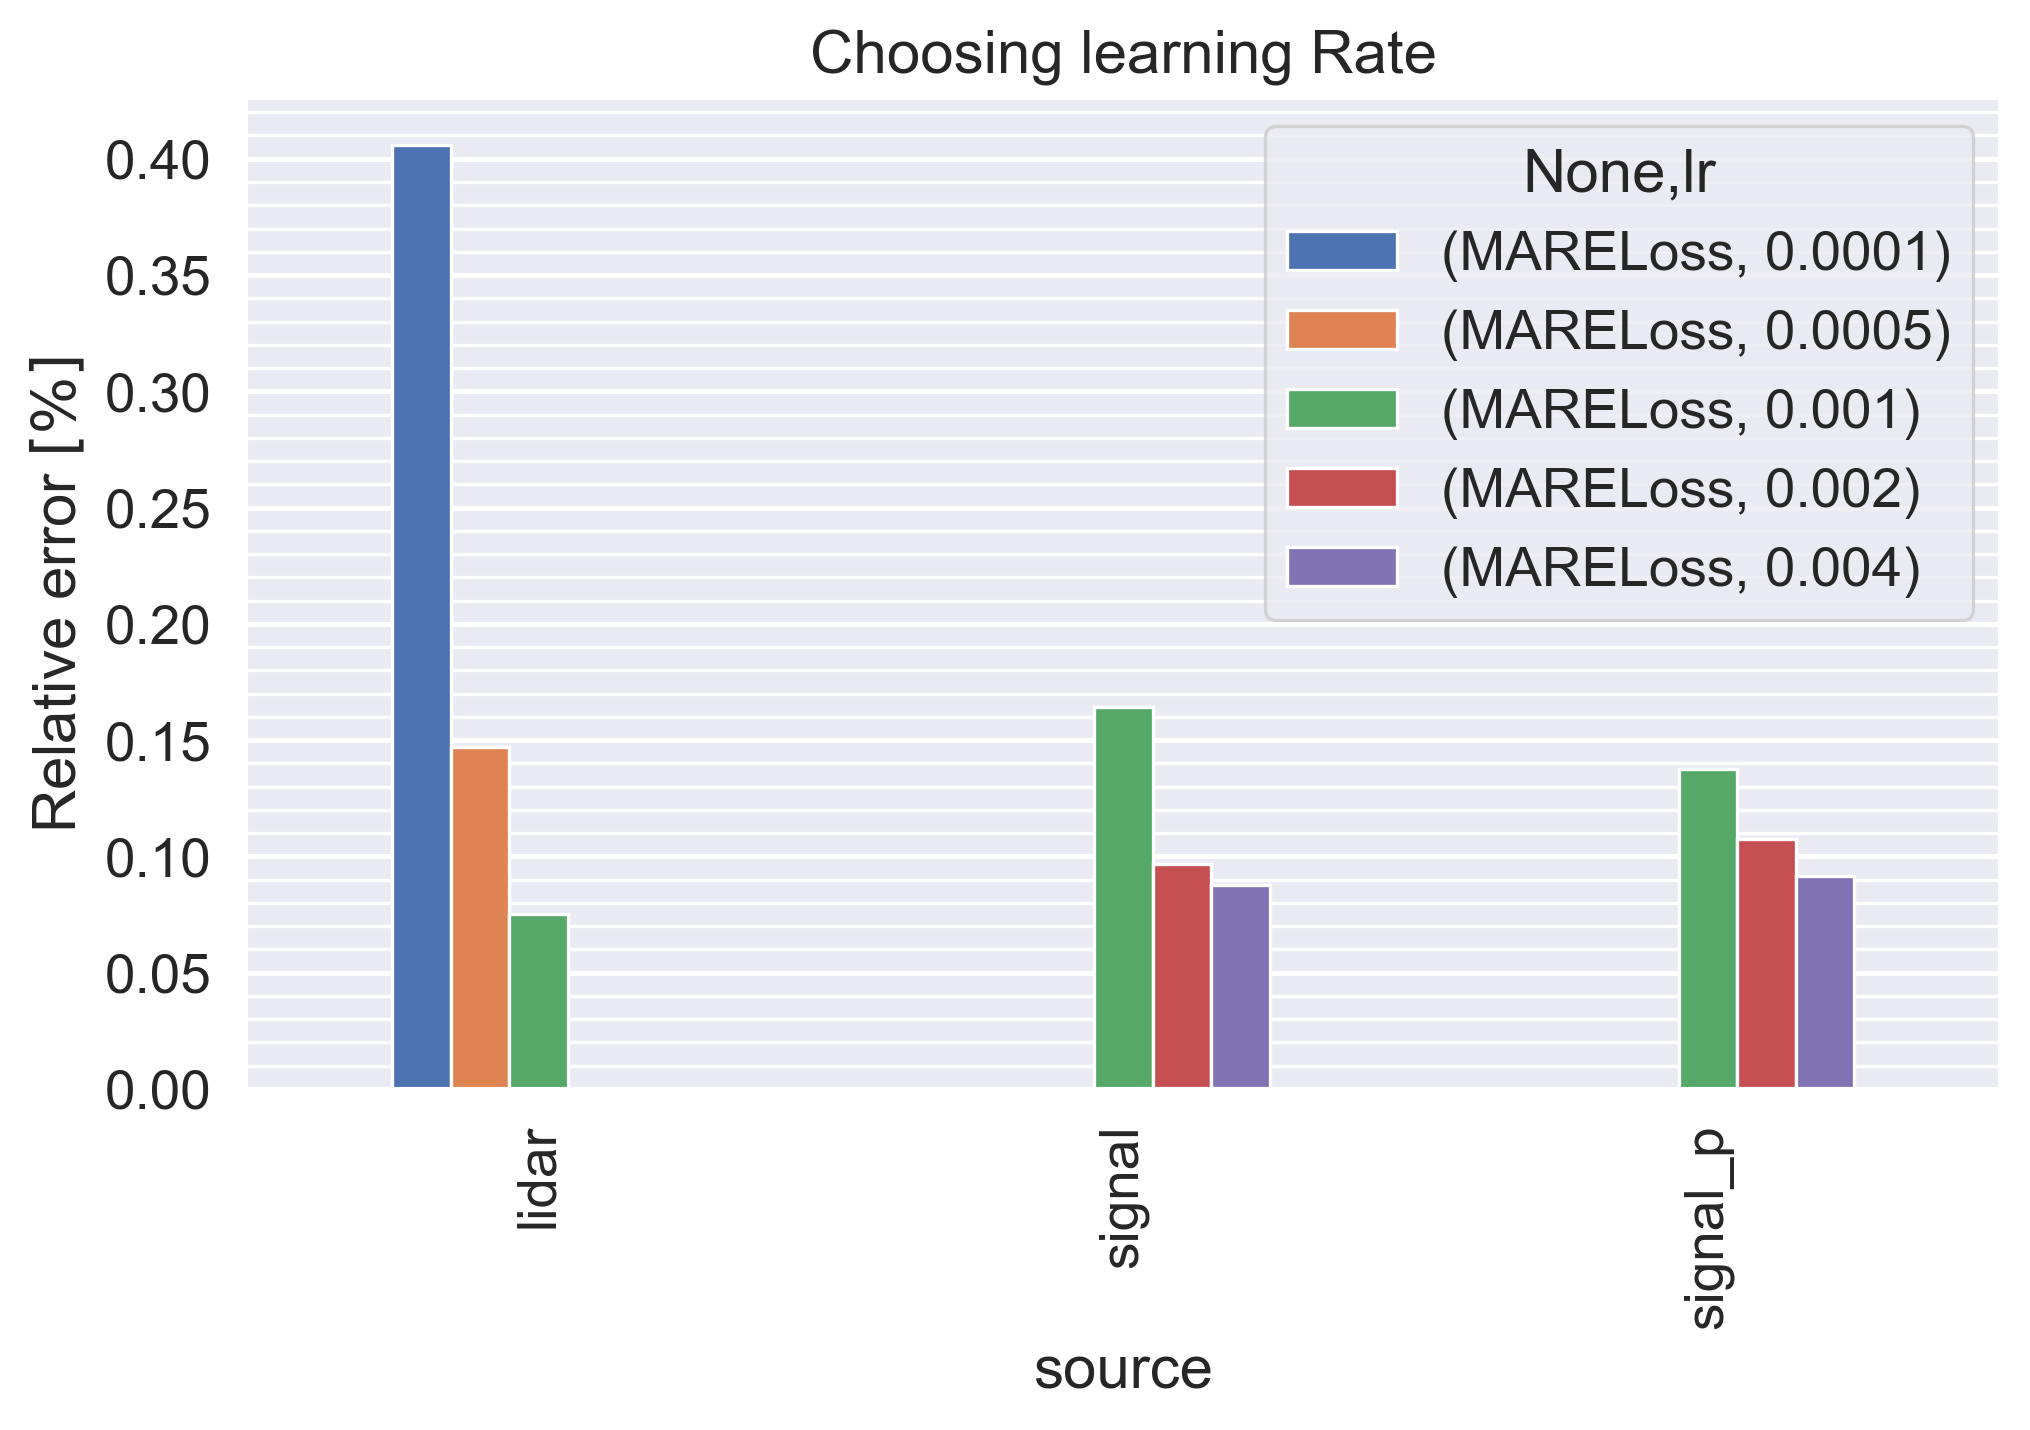

In [117]:
lidar_res = analyse_results#[analyse_results.source=='lidar' ]
lidar_res = lidar_res[lidar_res.use_bg==False]
pow_lidar = lidar_res[(~lidar_res.dnorm & lidar_res.use_power ) ]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar[pow_lidar.bsize==32][pow_lidar.fc_size>4],#[pow_lidar.note=='ok'],
               values=['MARELoss'],
               columns= ['lr'],
               index=['source'],#'fc_size'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Choosing learning Rate')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
ax.set_ylabel(r'Relative error $[\%]$')
plt.tight_layout()
plt.show()

## 2. FC vs. hidden sizes
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar
> lr = 0.001 or lr = 0.005

In [ ]:
all_wav = analyse_results #[analyse_results.wavelength=='all']
all_wavs_configABCD = all_wav[all_wav.config!='Other']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='initial_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Average loss on initial database \n Wavelengths separation comparison ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-122-4126b197b410>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='initial_db'],


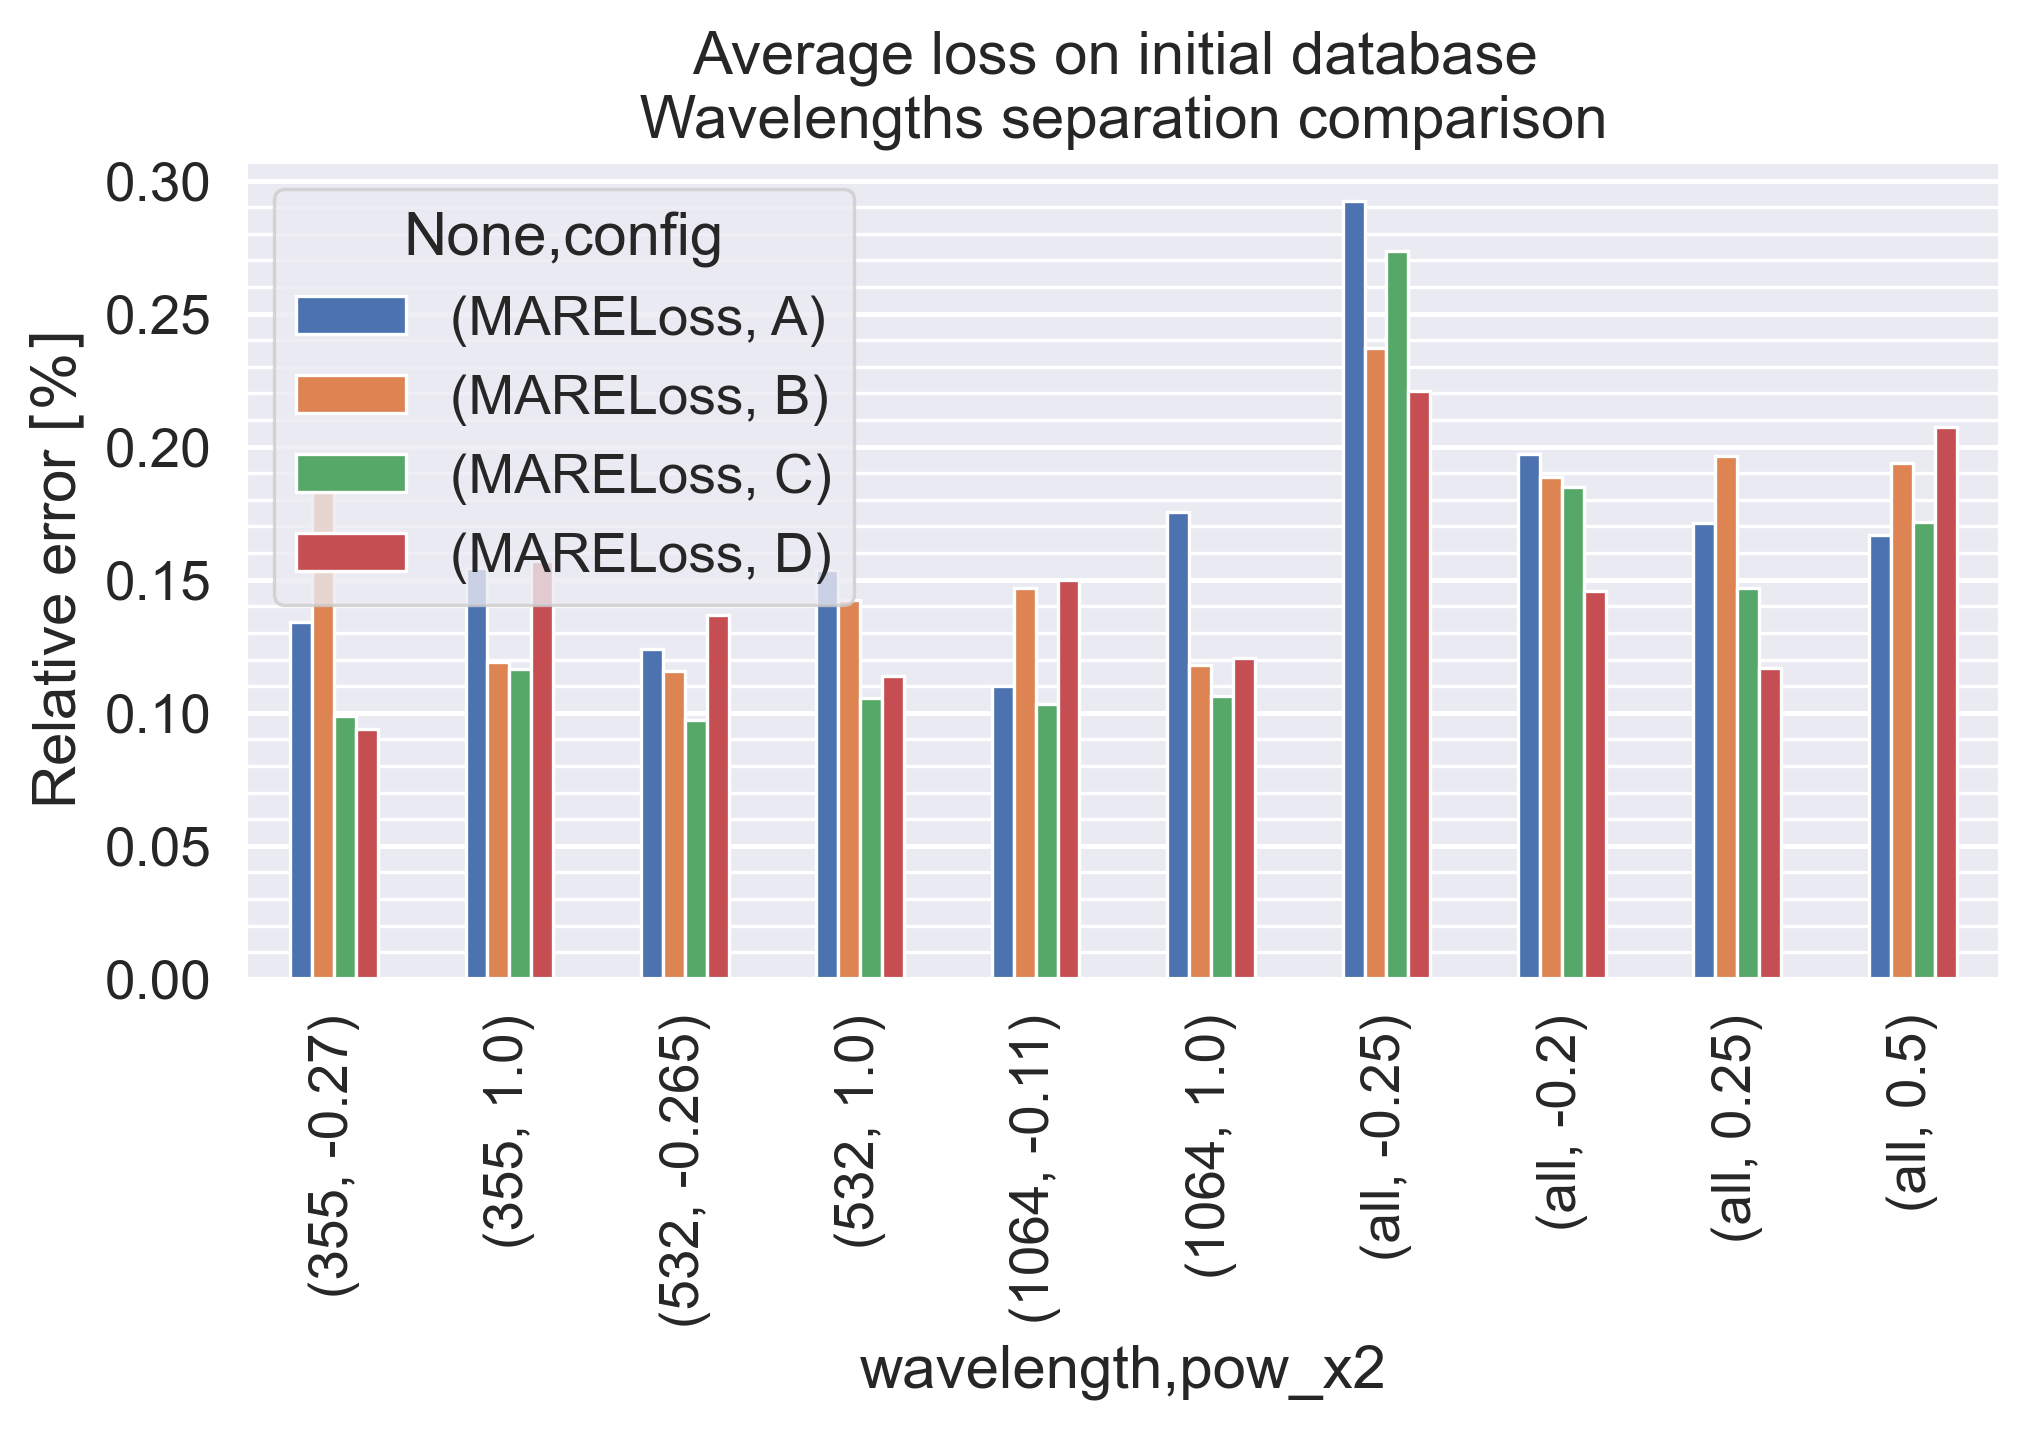

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='initial_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','pow_x2'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Average loss on initial database \n Wavelengths separation comparison ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

In [121]:
all_wavs_configABCD.powers

1      ([0.5, -0.25, 1], [0.5])
2        ([0.5, 0.5, 1], [0.5])
3       ([0.5, -0.2, 1], [0.5])
6      ([0.5, -0.25, 1], [0.5])
8        ([0.5, 0.5, 1], [0.5])
                 ...           
551      ([0.5, 1, 0.5], [0.5])
552      ([0.5, 1, 0.5], [0.5])
553        ([0.5, 1, 1], [0.5])
554      ([0.5, 1, 0.5], [0.5])
555        ([0.5, 1, 1], [0.5])
Name: powers, Length: 352, dtype: object

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(pow_lidar[pow_lidar.bsize==32][pow_lidar.fc_size!=4],#[pow_lidar.lr!=0.0001],
               values=['MARELoss'],
               columns= ['hsizes','wavelength'],
               index=['fc_size'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='FC size vs. inner layers` hidden sizes')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

## 3. Normalization vs. Power transform
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_power = False
> source = lidar

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(lidar_res[lidar_res.training_iteration>=4],
               values=['MARELoss'],
               columns= ['dnorm','use_power'],
               index=['fc_size','bsize'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Normalization vs. Power transform')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

## 3. Type of Power transform
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> source = lidar
> use_bg = False
> dnorm = False
> lr = 0.001

In [ ]:
pow_lidar = analyse_results[analyse_results.source=='lidar']
pow_lidar= pow_lidar[~pow_lidar.dnorm]
pow_lidar= pow_lidar[pow_lidar.use_bg==False]
pow_lidar= pow_lidar[pow_lidar.use_power]
pow_lidar = pow_lidar[pow_lidar.lr==0.001]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar,
               values=['MARELoss'],
               columns= ['pow_y' ],
               index=['fc_size','note'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Choosing Power Transform')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar[pow_lidar['pow_y']==0.5][(pow_lidar['pow_x1']==0.5)][pow_lidar['pow_x2']!=-0.2][pow_lidar['pow_x2']!=0.5],
               values=['MARELoss'],
               columns= ['pow_x2'], #'fc_size'
               index=['hsizes','note'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Choosing Power Transform. $\gamma_{x1}=0.5 , \gamma_y=0.5$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar[(pow_lidar['pow_y']==0.5)][(pow_lidar['pow_x1']==0.5)][pow_lidar['pow_x2']!=-0.2][pow_lidar['pow_x2']!=0.5][pow_lidar['training_iteration']>=4],
               values=['MARELoss'],
               columns= ['fc_size'],
               index=['wavelength','note','pow_x2'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Choosing Power Transform. $\gamma_{x1}=0.5 , \gamma_y=0.5$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

## 3. Type of source
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_power = True
> use_bg = False
> source = all
> dnorm = True
> lr > 0.0001

In [ ]:
sources_res = analyse_results[(analyse_results.use_power &
                             ~analyse_results.dnorm)]
sources_res[sources_res.use_bg==False]
sources_res = analyse_results[analyse_results.lr==0.001]
sources_res = analyse_results[analyse_results.fc_size>4]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(sources_res,#[sources_res.training_iteration>=4],
               values=['MARELoss'],
               columns= ['source'],
               index=['fc_size','note'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Testing different sources')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(sources_res,
               values=['MARELoss'],
               columns= ['source'],
               index=['hsizes','note'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Testing different sources')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

## 3. Adding
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_power = True
> fc_size>4
> source = lidar
> dnorm = False
> lr==0.001
> pow_y = 0.5

In [ ]:
bg_res = analyse_results[analyse_results.source=='lidar']
bg_res = bg_res[bg_res.use_power &
                ~bg_res.dnorm ]
bg_res = bg_res[bg_res.lr==0.001]
bg_res = bg_res[bg_res.fc_size>4]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res,
               values=['MARELoss'],
               #columns= ['pow_x2'],#'pow_x'],
               index=['use_bg','note'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing additional channel of $<p_{bg}> $')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.wavelength==1064],
               values=['MARELoss'],
               columns= ['pow_x2'],
               index=['use_bg','note'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing additional channel of $<p_{bg}> $')
plt.tight_layout()

ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.wavelength==1064],
               values=['MARELoss'],
               columns= ['pow_x3','pow_x2','fc_size'],
               index=['hsizes','note'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing power transform on additional channel of $<p_{bg}>$,$\gamma_{x1}=0.5$, $\gamma_{x2}=-0.25$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.use_bg!=False],
               values=['MARELoss'],
               columns= ['fc_size','pow_x3','pow_x2'],
               index=['hsizes'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing layers vs FC for $\gamma_{x1}=0.5$, $\gamma_{x2}=-0.25$, $\gamma_{x3}=1$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.wavelength==355],
               values=['MARELoss'],
               columns= ['note','pow_x2','pow_x3'],
               index=['hsizes','use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing layers vs FC for $\gamma_{x1}=0.5$, $\gamma_{x2}=-0.25$, $\gamma_{x3}=1$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.wavelength==532][bg_res.training_iteration>=11],
               values=['MARELoss'],
               columns= ['note','pow_x2','pow_x3'],
               index=['hsizes','use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing layers vs FC for $\gamma_{x1}=0.5$, $\gamma_{x2}=-0.25$, $\gamma_{x3}=1$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.note=='initial_db'][bg_res.use_bg==False],
               values=['MARELoss'],
               columns= ['hsizes','fc_size'],
               index=['use_bg','wavelength'], #'pow_x2',
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title=r'Testing power transform on second channel $\gamma_{x1}=0.5$, $\gamma_{x3}=1$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.legend( loc="lower center")
plt.tight_layout()
plt.show()

In [ ]:
bg_res =bg_res[bg_res.note=='extended_db']

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.use_bg=='True'], #[bg_res.pow_x3!=1.0],#[bg_res.pow_x3==1.0],
               values=['MARELoss'],
               columns= ['hsizes','fc_size'],
               index=['wavelength','pow_x2'],#'pow_x3'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing power transform on second channel $\gamma_{x1}=0.5$, $\gamma_{x3}=1$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.legend( loc="lower center")
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.pow_x1==0.5][bg_res.wavelength==355],
               values=['MARELoss'],
               columns= ['pow_x3'] ,#'hsizes','fc_size'],
               index=['pow_x2','note','use_bg','hsizes'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing power transform on second channel $\gamma_{x1}=0.5$, $\gamma_{x3}=1$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.legend( loc="lower center")
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.pow_x1==0.5][bg_res.wavelength==532],
               values=['MARELoss'],
               columns= ['pow_x3'] ,#'hsizes','fc_size'],
               index=['pow_x2','note','use_bg','hsizes'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing power transform on second channel $\gamma_{x1}=0.5$, $\gamma_{x3}=1$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.legend( loc="lower center")
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.pow_x1==0.5][bg_res.wavelength==1064],
               values=['MARELoss'],
               columns= ['pow_x3'] ,#'hsizes','fc_size'],
               index=['pow_x2','note','use_bg','hsizes'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing power transform on second channel $\gamma_{x1}=0.5$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.legend( loc="lower center")
plt.tight_layout()
plt.show()

# Create a list of chec_points/experiments to restore (run from begining)

In [ ]:






# TODO: show figure of different power transform on bg only
# TODO: show r^2 * pbg
# TODO: onclude O(r)
# TODO : a single FC
